# Assignment — Generative network models

# Salman Hussain

In [1]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import trange, tqdm
import random
import scipy
import itertools
import numpy as np

### Task 1. Watts-Strogatz model (0 points)

Implement Watts-Strogatz model (small-world model) — rewire an edge with probability `p` in a ring lattice with `n` nodes and `k` degree.

In [2]:
def watts_strogatz_graph(n, k, p):
    G = ring_lattice(n, k)
    for node in tqdm(G.nodes):
        rewire(G, node, k, p)
    return G

Write a function `ring_lattice` that returns a regular ring lattice with `n` nodes (0, 1, 2, ..., n-1) and `k` node degree. In a case of an odd node degree, it round it to the nearest smaller even number.

In [3]:
def ring_lattice(n, k):
    # YOUR CODE HERE
    G = nx.Graph()
    nodes = np.arange(0, n)
    G.add_nodes_from(nodes)

    for i in range(1, int(k/2 + 1)):
      G.add_edges_from(zip(nodes, (nodes + i) % n))
    return G

In [4]:
assert nx.degree_histogram(ring_lattice(10, 2))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 3))[2] == 10
assert nx.degree_histogram(ring_lattice(10, 4))[4] == 10

Write a function `rewire` that takes in input a ring lattice `G`, a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.*

![](https://raw.githubusercontent.com/netspractice/network-science/main/images/watts_strogatz_how_to_rewire.png)

* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

In [5]:
def rewire(G, node, k, p):
    # YOUR CODE HERE
    for i in range(node+1, node+int(k/2 + 1)):
      r = np.random.rand()
      if r < p:
        target = np.random.choice(len(G.nodes))
        if G.has_edge(node, target) or target == node: continue

        G.remove_edge(node, i % len(G.nodes))
        G.add_edge(node, target)

In [6]:
cases = [[50, 8, 0.1],
         [1000, 10, 0.01],
         [1000, 10, 0.5],
         [1000, 10, 0.99]]
for n, k, p in cases:
    G = watts_strogatz_graph(n, k, p)
    assert nx.number_of_nodes(G) == n
    assert nx.number_of_edges(G) == int(k / 2 * n)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.watts_strogatz_graph(n, k, p, 1)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Let us draw a small-world graph in some steps of the algorithm

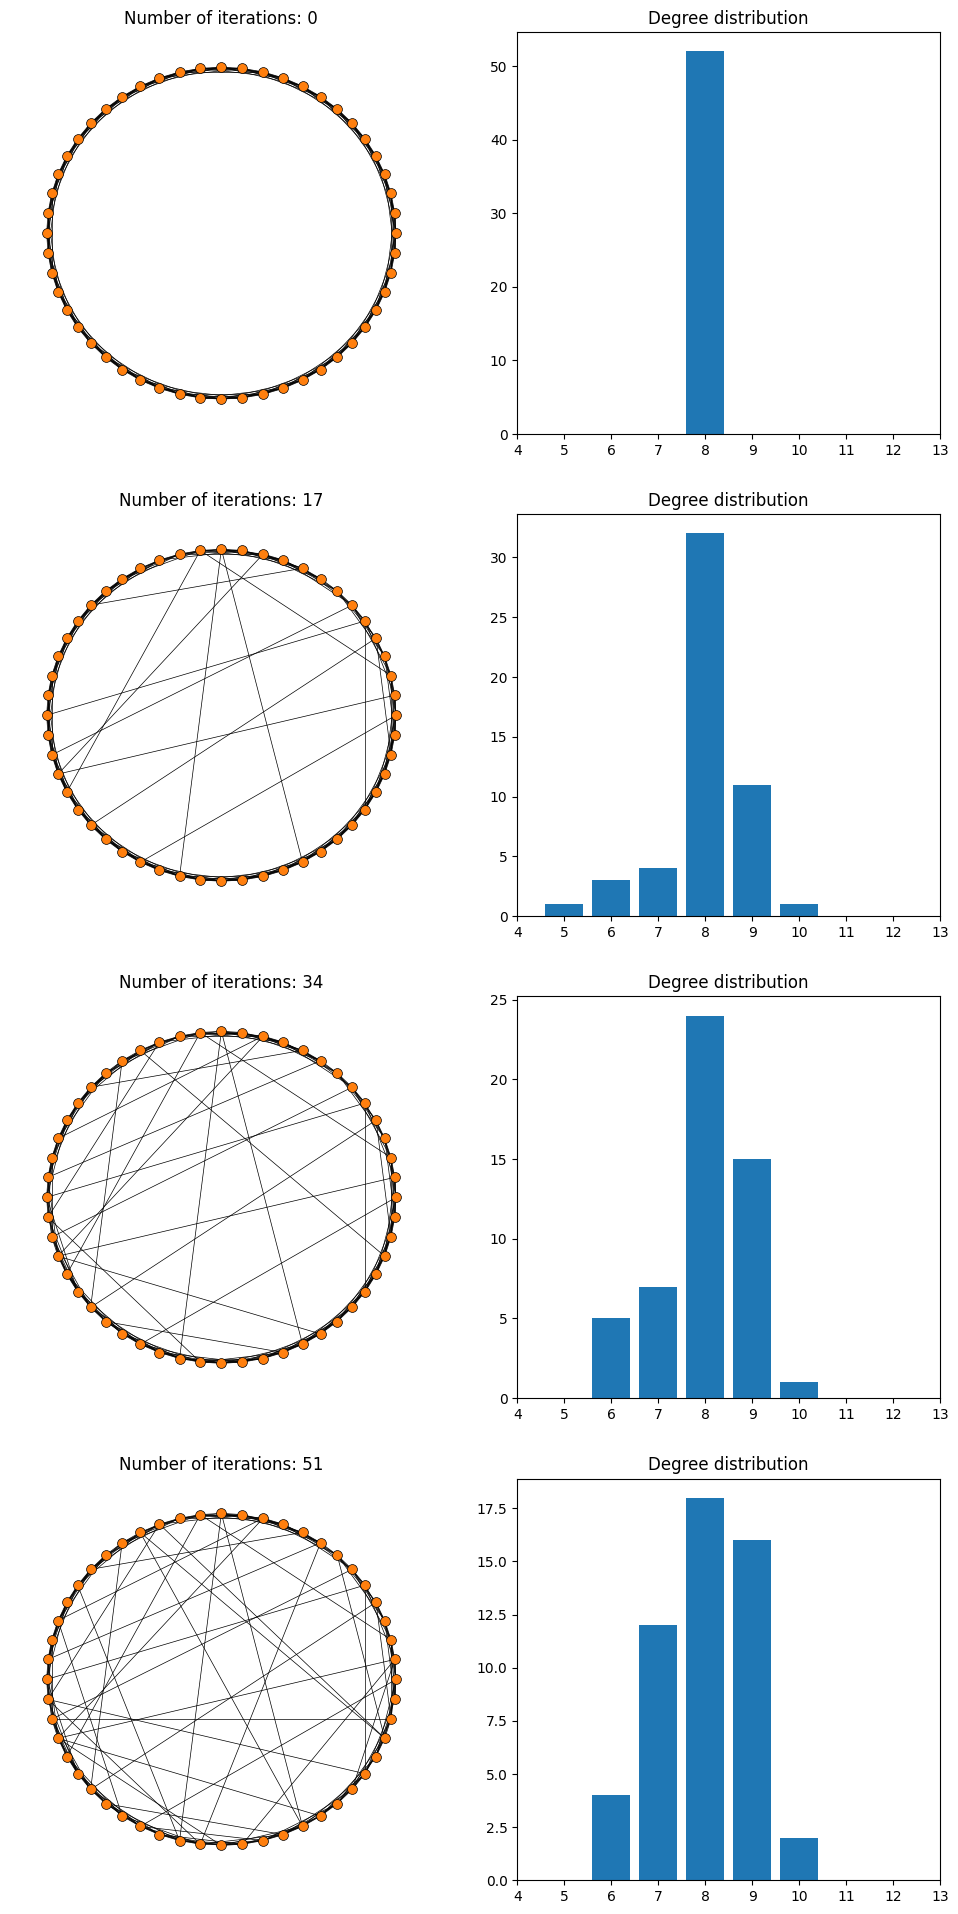

In [7]:
n, k, p = 52, 8, 0.2
G = ring_lattice(n, k)
plt.figure(figsize=(12, 6 * 4))
i = 1
for node in G.nodes:
    if node in np.arange(0, n+1, int(n/3)):
        plt.subplot(4, 2, i)
        plt.title('Number of iterations: {}'.format(node))
        nx.draw_circular(
            G,
            node_size=50,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        i += 1
        plt.subplot(4, 2, i)
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.bar(bins, freq)
        plt.xlim((4, 13))
        plt.title('Degree distribution')
        i += 1
    rewire(G, node, k, p)

### Task 2. Average path length in Watts-Strogatz model (2 points)

Let us check that the average path length tends to theoretical value during building the small-world model.

$$\langle L \rangle = \begin{cases}
N/2k, \text{ if } p \to 0 \\
\log(N)/\log(k), \text{ if } p \to 1
\end{cases}$$

So that we have a lower and upper limits of path lengths for $0 < p < 1$.

Write a function `smallworld_path_len` with Watts-Strogatz model parameters `n, k, p` that returns np.array of average path lengths in each step (node). The length of the array is `n`.

*Hint: to calculate the average shortest path length, use `nx.average_shortest_path_length`*

In [8]:
def smallworld_path_len(n, k, p):
    G = ring_lattice(n, k)
    avg_path_lengths = []
    for node in range(n):
        rewire(G, node, k, p)
        avg_path_lengths.append(nx.average_shortest_path_length(G))
    return np.array(avg_path_lengths)

In [9]:
n, k, p = 101, 10, 0.05
lengths = smallworld_path_len(n, k, p)
step_space = np.log(np.arange(1, len(lengths) + 1))
X = np.stack([step_space, np.ones(lengths.shape[0])], axis=1)
assert lengths.shape[0] == n
assert 0.1 < -(np.linalg.pinv(X) @ np.log(lengths))[0] < 0.25

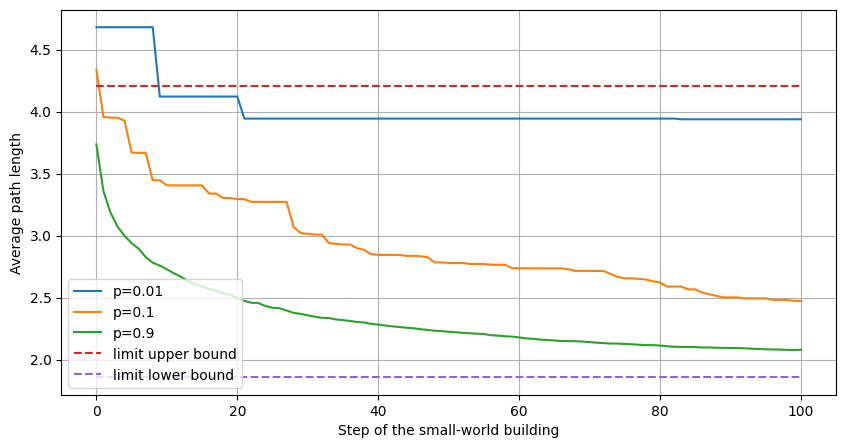

In [10]:
plt.figure(figsize=(10, 5))

n, k, p = 101, 12, 0.01
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.1
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

n, k, p = 101, 12, 0.9
lengths = smallworld_path_len(n, k, p)
plt.plot(lengths, label=f'p={p}')

plt.xlabel('Step of the small-world building')
plt.ylabel('Average path length')
plt.grid()
plt.plot([0, 100], [n / 2 / k, n / 2 / k], '--',
         label='limit upper bound')
plt.plot([0, 100], [np.log(n) / np.log(k), np.log(n) / np.log(k)], '--',
         label='limit lower bound')
plt.legend(loc='lower left')
plt.show()

### Task 3. Barabasi-Albert model (0 points)

Implement Barabasi-Albert model (preferential attachment model) – a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is
$$p(i) = \frac{k_i}{\sum k}$$

Write a function `attach` that attaches a `node` to a graph `G` through `m` edges.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [11]:
'''Do not touch the cell'''
def barabasi_albert_graph(n, m):
    G = nx.star_graph(m)
    for i in trange(1, n - m):
        attach(m + i, G, m)
    return G

In [12]:
def attach(node, G, m):
    # YOUR CODE HERE
    '''
    degrees = np.array([G.degree[i] for i in G.nodes])
    probs = degrees / degrees.sum()

    neigs = np.random.choice(G.nodes, p=probs, size=m, replace=False)
    for nei in neigs:
      G.add_edge(node, nei)
    '''

    edges_flatten = []
    for u, v in G.edges:
      edges_flatten.append(u)
      edges_flatten.append(v)

    neigs = set()
    while len(neigs) < m:
      nei = random.choice(edges_flatten)
      neigs.add(nei)

    for nei in neigs:
      G.add_edge(node, nei)

In [13]:
G = nx.star_graph(3)
attach(4, G, 3)
assert nx.number_of_edges(G) == 6

cases = [[10, 3],
         [1000, 3],
         [1000, 20]]
for n, m in cases:
    G = barabasi_albert_graph(n, m)
    degree_seq = [degree for (node, degree) in G.degree]
    nxG = nx.barabasi_albert_graph(n, m)
    nxdegree_seq = [degree for (node, degree) in nxG.degree]
    assert ks_2samp(degree_seq, nxdegree_seq).pvalue > 0.05

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/996 [00:00<?, ?it/s]

  0%|          | 0/979 [00:00<?, ?it/s]

Let us see what the growth process looks like

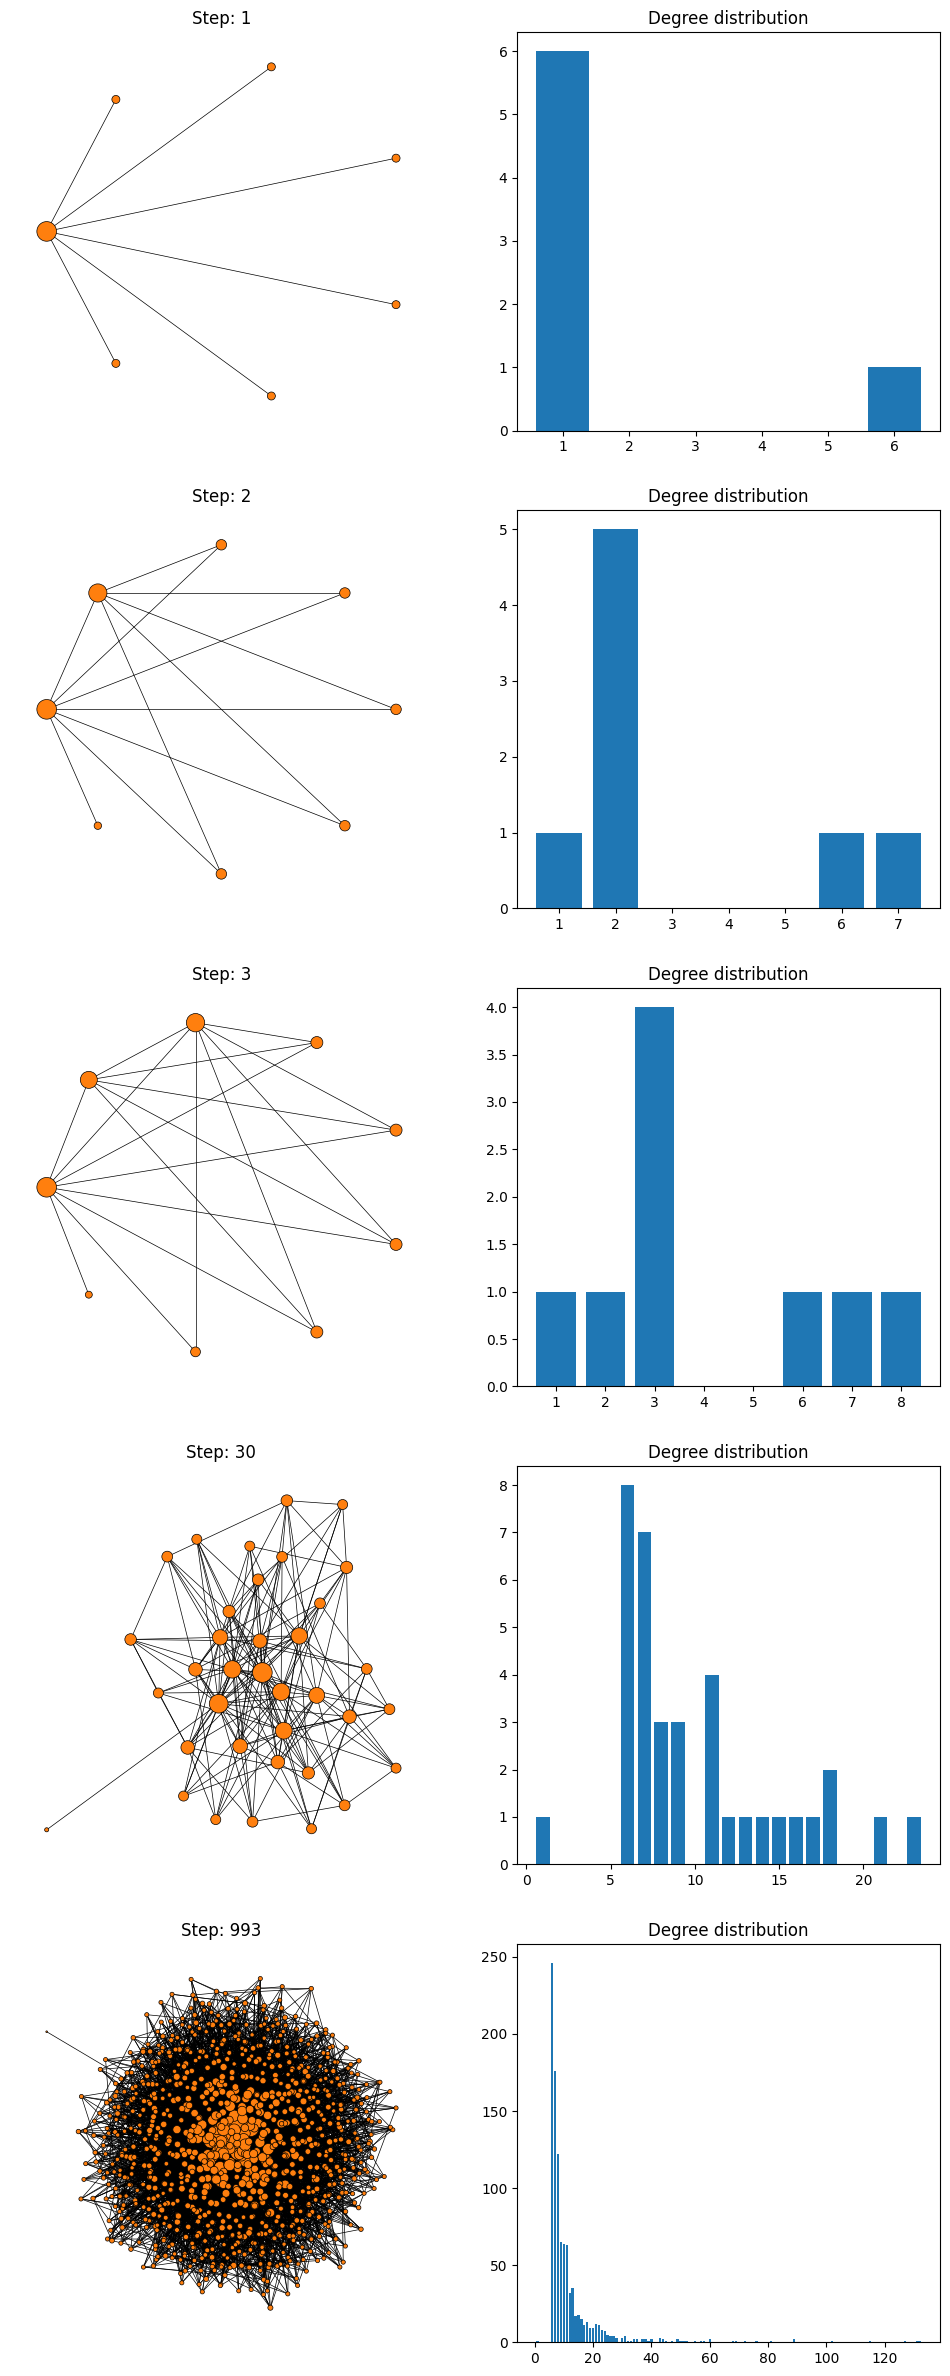

In [14]:
n, m = 1000, 6
G = nx.star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in range(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(G).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(G)
        else:
            pos = nx.layout.spring_layout(G)
        nx.draw(
            G,
            pos=pos,
            with_labels=False,
            node_size=sizes,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in G.degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

### Task 4. Degree distribution in Barabasi-Albert model (3 points)

Barabasi-Albert graph has a degree distribution of the form

$$P(k) = \frac{2m^2}{k^3}$$

That is Power law with $\alpha = 3$ and $k_\min = m$.

Check this fact by an experiment — generate a set of Barabasi-Albert graphs and estimate parameters of Power law using MLE

$$\alpha = 1 + n \left[\sum_i \log \frac{k_i}{k_\min} \right]^{-1}$$

where the $k_\min$ is selected by minimal Kolmogorov-Smirnov distance between observed and theoretical distributions.

First, write a function `power_law_cdf` that takes an argument and parameters of the Power law distribution and returns the CDF.

In [15]:
def power_law_cdf(k, alpha=3.5, k_min=1):
    return 1 - (k_min / k) ** (alpha - 1)

In [16]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9

Next, write a function `mle_power_law_params` that takes a degree sequence and returns a tuple: the best $\alpha$, w.r.t. MLE, the best $k_\min$ w.r.t. Kolmogorov-Smirnov distance

_Hint: use `scipy.stats.kstest` where a theoretical CDF is a `power_law_cdf` function and `args=(alpha, k_min)`_

In [17]:
def mle_power_law_params(degree_sequence):
    deg_seq = np.sort(degree_sequence)
    k_mins = range(1, int(np.max(deg_seq)))
    best_alpha = None
    best_k_min = None
    min_ks_distance = float('inf')
    for k_min in k_mins:
        filtered_degrees = deg_seq[deg_seq >= k_min]
        if len(filtered_degrees) == 0:
            continue
        alpha = 1 + len(filtered_degrees) / np.sum(np.log(filtered_degrees / k_min))
        ks_distance = scipy.stats.kstest(filtered_degrees, lambda x: power_law_cdf(x, alpha, k_min))[0]
        if ks_distance < min_ks_distance:
            best_alpha, best_k_min, min_ks_distance = alpha, k_min, ks_distance
    return best_alpha, best_k_min

In [18]:
assert mle_power_law_params(np.array([1, 2, 3]))[0] > 0
assert mle_power_law_params(np.array([1, 2, 3]))[1] > 0

Write a function `estimate_power_law` that generates Barabasi-Albert graphs with `n` nodes, from `m_min` to `m_max` connections and returns a tuple of np.arrays: $\alpha$ and $k_{\min}$ for each graph.

In [19]:
def estimate_power_law(n, m_min, m_max):
    alpha, kmin = [], []
    for m in range(m_min, m_max + 1):
        G = barabasi_albert_graph(n, m)
        degree_sequence = np.array([degree for node, degree in G.degree()])
        alp, k_mins = mle_power_law_params(degree_sequence)
        alpha.append(alp)
        kmin.append(k_mins)
    return np.array(alpha), np.array(kmin)

In [20]:
'''Check the Power law parameters'''
n, m_min, m_max = 500, 2, 20
alpha, k_min = estimate_power_law(n, m_min, m_max)
assert alpha.shape[0] == m_max - m_min + 1
assert 2 < alpha.mean() < 4
assert k_min[0] < k_min[-1]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/496 [00:00<?, ?it/s]

  0%|          | 0/495 [00:00<?, ?it/s]

  0%|          | 0/494 [00:00<?, ?it/s]

  0%|          | 0/493 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

  0%|          | 0/490 [00:00<?, ?it/s]

  0%|          | 0/489 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

  0%|          | 0/481 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

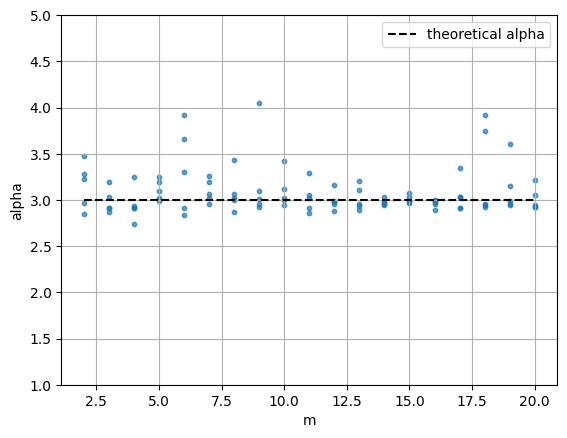

In [21]:
n, m_min, m_max = 500, 2, 20
m_space = np.arange(m_min, m_max + 1)
for _ in range(5):
    alpha, k_min = estimate_power_law(n, m_min, m_max)
    plt.scatter(m_space, alpha, alpha=0.7, c='tab:blue', s=10)
plt.plot([2, 20], [3, 3], 'k--', label='theoretical alpha')
plt.ylim((1, 5))
plt.xlabel('m')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

### Task 5. Clustering coefficient in Barabasi-Albert model (2 points)

Measure the average clustering coefficient in function of N using Barabasi-Albert model.

Write a function `generate_clustering_coef` that takes np.array with list of `n` values for each graph and parameter `m`. The function generate Barabasi-Albert graphs and returns np.array of average clustering coefficients.

In [22]:
def generate_clustering_coef(n_list, m):
    clustering_coeffs = []
    for n in n_list:
        G = nx.barabasi_albert_graph(n, m)
        avg_clustering = nx.average_clustering(G)
        clustering_coeffs.append(avg_clustering)
    return np.array(clustering_coeffs)

In [23]:
n_list = np.arange(100, 3100, 100)
m = 6
coeffs = generate_clustering_coef(n_list, m)
assert coeffs.shape == (30,)
X = np.log(n_list)
X = np.stack([np.ones_like(X), X], axis=1)
Y = np.log(coeffs)[:, None]
assert -0.78 < (np.linalg.pinv(X) @ Y)[1][0] < -0.63

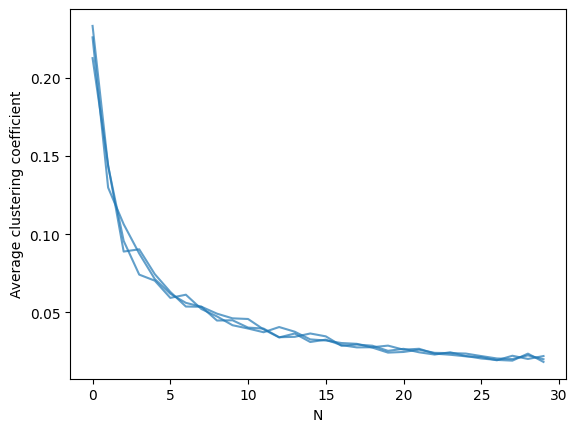

In [24]:
n_list = np.arange(100, 3100, 100)
m = 6
for _ in range(3):
    coeffs = generate_clustering_coef(n_list, m)
    plt.plot(coeffs, c='tab:blue', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Average clustering coefficient')
plt.show()

### Task 6. Degree dynamics in Barabasi-Albert model (3 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

Write a function `generate_degree_dynamics` that takes np.array with considered nodes, generates Barabasi-Albert graph ($n=3000$, $m=6$) and returns a np.array of the shape `(30, len(cons_nodes))` — degrees of these nodes at time moments when nodes 99, 199, 299, ..., 2999 appear. If a node does not exist yet, pass `np.nan` value.

*Hint: use the `barabasi_albert_graph` function as a template*

In [25]:
def generate_degree_dynamics(cons_nodes):
    n = 3000
    m = 6
    time_space = np.arange(99, 3000, 100)
    degree_dynamics = np.full((30, len(cons_nodes)), np.nan)
    G = nx.complete_graph(m)
    for t in range(m, n):
        targets = list(G.nodes())
        weights = np.array([G.degree(node) for node in targets])
        new_edges = np.random.choice(targets, size=m, replace=False, p=weights/sum(weights))
        G.add_node(t)
        G.add_edges_from([(t, target) for target in new_edges])
        if t in time_space:
            idx = np.where(time_space == t)[0][0]
            degree_dynamics[idx] = [G.degree[node] if node <= t else np.nan for node in cons_nodes]
    return degree_dynamics

In [26]:
degree_dynamics = generate_degree_dynamics([99, 199, 699, 1999])
assert degree_dynamics.shape == (30, 4)
assert np.all(np.isnan(degree_dynamics[0]) == [False, True,  True,  True])
assert np.all(np.isnan(degree_dynamics[9]) == [False, False,  False,  True])
assert degree_dynamics[0, 0] < degree_dynamics[-1, 0]
assert degree_dynamics[1, 1] < degree_dynamics[-1, 1]
assert degree_dynamics[-1, 0] > degree_dynamics[-1, 3]

  0%|          | 0/5 [00:00<?, ?it/s]

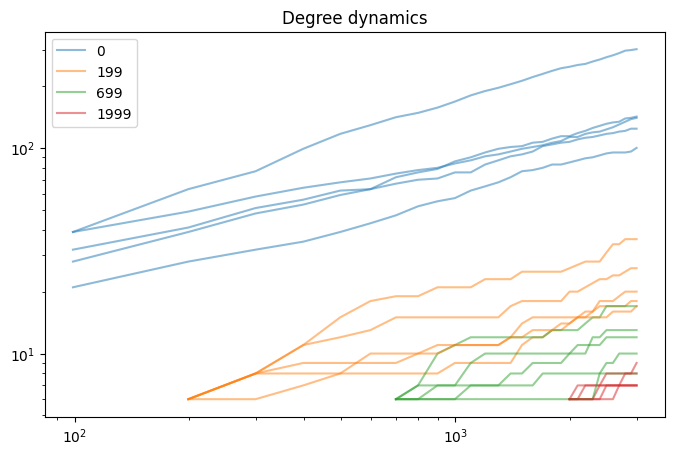

In [27]:
cons_nodes = [0, 199, 699, 1999]
colors = plt.cm.tab10.colors
plt.figure(figsize=(8, 5))
for _ in trange(5):
    degree_dynamics = generate_degree_dynamics(cons_nodes)
    time_space = np.arange(99, 3000, 100)
    for i in range(4):
        plt.plot(time_space, degree_dynamics[:, i], c=colors[i], alpha=0.5)
plt.legend(cons_nodes)
plt.title('Degree dynamics')
plt.xscale('log')
plt.yscale('log')
plt.show()